In [1]:
from scipy.io import loadmat
from scipy.stats import circmean, circstd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd

from utils import validate_data

## Loading all the data

In [2]:
# Set in stone
data_path = './axej_eeg/'
n_subjects = 13
n_sessions = 4
n_runs = 6
n_trials = 120
n_ts = 500

exp_ts = 1000

# noise frames = 0 to 220 (250 - 30)
noise_thresh = 0.5
noise_gap = 30


experiment_orientations = [159, 123, 87, 51, 15]
subjects = ["01", "02", "03", "04", "05", "06", "07", "08" ,"09", "10", "11", "12", "13"]
subjects_name = ["01", "02", "03", "04", "05", "06", "07", "08" ,"09", "10", "11", "12", "14"]

def get_calib(subj, sess):
    mat_contents = loadmat(data_path + f'AxeJEEG_Subj{subjects_name[subj]}_S{sess+1}_Cali1.mat.mat', struct_as_record=False, squeeze_me=True)
    return mat_contents["p"].__dict__

def get_run(subj, sess, run):
    mat_contents = loadmat(data_path + f'AxeJEEG_Subj{subjects_name[subj]}_S{sess+1}_Run{run+1}.mat.mat', struct_as_record=False, squeeze_me=True)
    return mat_contents["p"].__dict__

In [3]:
# Get all run data
# subjexts x sessions x runs
jx = []
jy = []
stimdir = []
tgonset = []

# Attention (attCue): tr_foc = 1, tr_div = 2
# Coherence (tgCoh): tr_lo = 1, tr_hi = 2
att = []
coh = []

for subj in tqdm(range(n_subjects)):
    for sess in range(n_sessions):
        for run in range(n_runs):

            data = get_run(subj, sess, run)
            jx.append(data["joyx"])
            jy.append(data["joyy"])
            stimdir.append(data["stimDirREAL"])

            f_tgonset = data["f_precuedur"] + data["f_cuedur"]
            tgonset.append(f_tgonset)

            att.append(data["attCue"])
            coh.append(data["tgCoh"])

# Shape the run data
jx = np.array(jx, dtype=np.float64).reshape(n_subjects, n_sessions, n_runs, n_trials, n_ts)
jy = np.array(jy, dtype=np.float64).reshape(n_subjects, n_sessions, n_runs, n_trials, n_ts)
stimdir = np.array(stimdir).reshape(n_subjects, n_sessions, n_runs, n_trials)
tgonset = np.array(tgonset).reshape(n_subjects, n_sessions, n_runs, n_trials)
att = np.array(att).reshape(n_subjects, n_sessions, n_runs, n_trials)
coh = np.array(coh).reshape(n_subjects, n_sessions, n_runs, n_trials)

jx.shape, jy.shape, stimdir.shape, tgonset.shape

100%|██████████| 13/13 [00:01<00:00, 12.37it/s]


((13, 4, 6, 120, 500), (13, 4, 6, 120, 500), (13, 4, 6, 120), (13, 4, 6, 120))

## Logic for Getting Valid Trials:

1. Get all the trials
2. Align all target onset at 250 ts
3. Get distance from center and angle from center
4. If the distance moves <0.4 au n frames before target onset. Then that trial is "too early" and all response set nan.
5. If ts has distance > 1 au then set its response angle to the last valid angle (if first, the nan) and set that distance to 1.
6. get angle first distance = 1 a.u. instance after target onset. or if it never reaches 1, then angle at max distance after target onset. as the response angle.

In [4]:
shifted_jx, shifted_jy, dist_from_cent, resp_angle, final_resp_angles, final_resp_idx = validate_data(n_subjects, n_sessions, n_runs, n_trials, n_ts, exp_ts, jx, jy, tgonset, noise_thresh, noise_gap)

In [5]:
# Get all trials where angles are only nan
nan_trials = np.where(np.isnan(resp_angle).all(axis=-1))
print(nan_trials[0].shape[0], "invalid trials")
print(nan_trials[0].shape[0] / (n_subjects * n_sessions * n_runs * n_trials) * 100, "% invalid trials")

2919 invalid trials
7.7964743589743595 % invalid trials


## Circular stat defs

In [6]:
def circdist(a, b):
    return min(abs(a-b), 360-abs(a-b))

def circmedian(angs):
    angs = np.array(angs)
    angs = angs[~np.isnan(angs)]
    pdists = angs[np.newaxis, :] - angs[:, np.newaxis]
    pdists = (pdists + 180) % (2 * 180) - 180
    pdists = np.abs(pdists).sum(1)
    return angs[np.argmin(pdists)]

In [7]:
calib_median = np.load("circ_median.npy")
median_key = {15:0, 51:1, 87:2, 123:3, 159:4}

In [8]:
calib_std = np.load("circ_std.npy")
std_key = {15:0, 51:1, 87:2, 123:3, 159:4}

## Seperating by accuracy

In [9]:
final_resp_angles.shape, stimdir.shape

((13, 4, 6, 120), (13, 4, 6, 120))

In [10]:
# One and two sigma distance from the calibration median

resp_correct_sigma = np.zeros_like(final_resp_angles)
resp_correct_sigma[:] = np.nan

resp_correct_two_sigma = np.zeros_like(final_resp_angles)
resp_correct_two_sigma[:] = np.nan

targ_calib = np.zeros_like(final_resp_angles)
targ_calib[:] = np.nan

for subj in range(n_subjects):
    for sess in range(n_sessions):
        for run in range(n_runs):
            for trial in range(n_trials):
                actual_stimdir = stimdir[subj,sess,run,trial]

                # Get the median and std for the actual stimdir
                calib_resp_median = calib_median[subj,median_key[actual_stimdir]]
                calib_resp_sigma = calib_std[subj,std_key[actual_stimdir]]

                # Get the response angle
                trial_response = final_resp_angles[subj,sess,run,trial]

                # Skip if the trial is 'too early'
                if np.isnan(trial_response): continue

                targ_calib[subj,sess,run,trial] = calib_resp_median

                # Check if the response is within 1 sigma or 2 sigma
                resp_correct_sigma[subj,sess,run,trial] = circdist(calib_resp_median, trial_response) <= calib_resp_sigma
                resp_correct_two_sigma[subj,sess,run,trial] = circdist(calib_resp_median, trial_response) <= calib_resp_sigma*2


In [11]:
targ_calib.shape, att.shape, coh.shape

((13, 4, 6, 120), (13, 4, 6, 120), (13, 4, 6, 120))

In [12]:
# replace 1 with -1 and 2 with 1
attention = np.where(att == 2, -1, 1)
coherence = np.where(coh == 1, -1, 1)

In [13]:
expected = np.zeros((n_subjects, n_sessions, n_runs))
expected[:] = np.nan
for subj in range(n_subjects):
    for sess in range(n_sessions):
        for run in range(n_runs - 1):
            vals, counts = np.unique(targ_calib[subj,sess,run], return_counts=True)
            expected[subj,sess,run] = vals[np.argmax(counts)]

# if expected is negative, then do 360 + expected
expected = np.where(expected < 0, 360 + expected, expected)

In [14]:
resp_df = pd.DataFrame({
    "subj": np.repeat(np.arange(n_subjects), n_sessions*n_runs*n_trials),
    "sess": np.tile(np.repeat(np.arange(n_sessions), n_runs*n_trials), n_subjects),
    "run": np.tile(np.repeat(np.arange(n_runs), n_trials), n_subjects*n_sessions),
    "trial": np.tile(np.arange(n_trials), n_subjects*n_sessions*n_runs),
    "target": stimdir.flatten(),
    "targ_calib": targ_calib.flatten(),
    "resp": final_resp_angles.flatten(),
    "expectation": np.tile(expected.reshape(n_subjects, n_sessions, n_runs, 1), 120).flatten(),
    "attention": attention.flatten(),
    "coherence": coherence.flatten(),
    "one_sigma": resp_correct_sigma.flatten(),
    "two_sigma": resp_correct_two_sigma.flatten()
})
resp_df.dropna(inplace=True)
resp_df

subj  sess  run  trial  target  targ_calib        resp  expectation  \
0         0     0    0      0     159  145.877462  150.877772   145.877462   
1         0     0    0      1     123  138.718044  127.920427   145.877462   
2         0     0    0      2      51   32.872185  131.003103   145.877462   
3         0     0    0      3     159  145.877462  144.775174   145.877462   
4         0     0    0      4      15   18.752776  142.791565   145.877462   
...     ...   ...  ...    ...     ...         ...         ...          ...   
37315    12     3    4    115     123  137.879638  144.683743     2.591583   
37316    12     3    4    116      15    2.591583  144.074142     2.591583   
37317    12     3    4    117      15    2.591583   28.548542     2.591583   
37318    12     3    4    118      15    2.591583   24.793549     2.591583   
37319    12     3    4    119     159  151.890213   92.711858     2.591583   

       attention  coherence  one_sigma  two_sigma  
0             -1          1        1.0        1.0  
1              1          1        1.0        1.0  
2              1          1        0.0        0.0  
3             -1          1        1.0        1.0  
4             -1         -1        0.0        0.0  
...          ...        ...        ...        ...  
37315         -1          1        1.0        1.0  
37316          1         -1        0.0        0.0  
37317          1         -1        0.0        0.0  
37318         -1         -1        0.0        0.0  
37319          1          1        0.0        0.0  

[27961 rows x 12 columns]

## Mixture

In [15]:
import numpy as np
import pymc as pm
import pytensor.tensor as pt

import arviz as az
az.style.use("arviz-doc")

In [16]:
x_tr = resp_df[["expectation", "attention", "coherence"]].values
x_tr[:, 0] = np.radians(x_tr[:, 0]) - np.pi

x_em = resp_df["targ_calib"].values
x_em = np.radians(x_em) - np.pi

y = resp_df["resp"].values
y = np.radians(y) - np.pi

# shuffle indices and select subset
idx = np.arange(len(y))
np.random.shuffle(idx)

# T = 27961
T = 3000

x_tr = x_tr[idx][:T]
x_em = x_em[idx][:T]
y = y[idx][:T]



x_tr.shape, x_em.shape, y.shape

((3000, 3), (3000,), (3000,))

In [17]:
# GLM experts
wmu = pt.as_tensor([-0.213,-0.644])
wit = pt.as_tensor([-2.054,-1.080])
kappa = pt.as_tensor([2.275,16.568])


with pm.Model() as model:
    a = pm.Normal('a', mu=0, sigma=1)
    b = pm.Normal('b', mu=0, sigma=1, shape=(3))

    # controller
    sig = pm.Deterministic('sig', pm.math.sigmoid(a + pm.math.dot(x_tr, b)))

    # z = pm.Bernoulli('z', logit_p=pm.math.sum(a, pm.math.dot(x_tr, b)), shape=(T))
    z = pm.Bernoulli('z', p=sig, shape=(T))
    
    # experts
    y = pm.VonMises('y', mu= pm.math.dot(x_em, wmu[z]) + wit[z], kappa=kappa[z], observed=y, shape=(T))

    trace = pm.sample(1000, return_inferencedata=True)
    

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [a, b]
>BinaryGibbsMetropolis: [z]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1191 seconds.
/home/nuttidalab/miniconda3/envs/ssm/lib/python3.10/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/nuttidalab/miniconda3/envs/ssm/lib/python3.10/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: divide by zero encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [27]:
# pickle save the model
trace.to_netcdf("independent.nc")

# trace = az.from_netcdf("independent.nc")

'independent.nc'

array([[<Axes: title={'center': 'a'}>, <Axes: title={'center': 'a'}>],
       [<Axes: title={'center': 'b'}>, <Axes: title={'center': 'b'}>],
       [<Axes: title={'center': 'sig'}>, <Axes: title={'center': 'sig'}>],
       [<Axes: title={'center': 'z'}>, <Axes: title={'center': 'z'}>]],
      dtype=object)

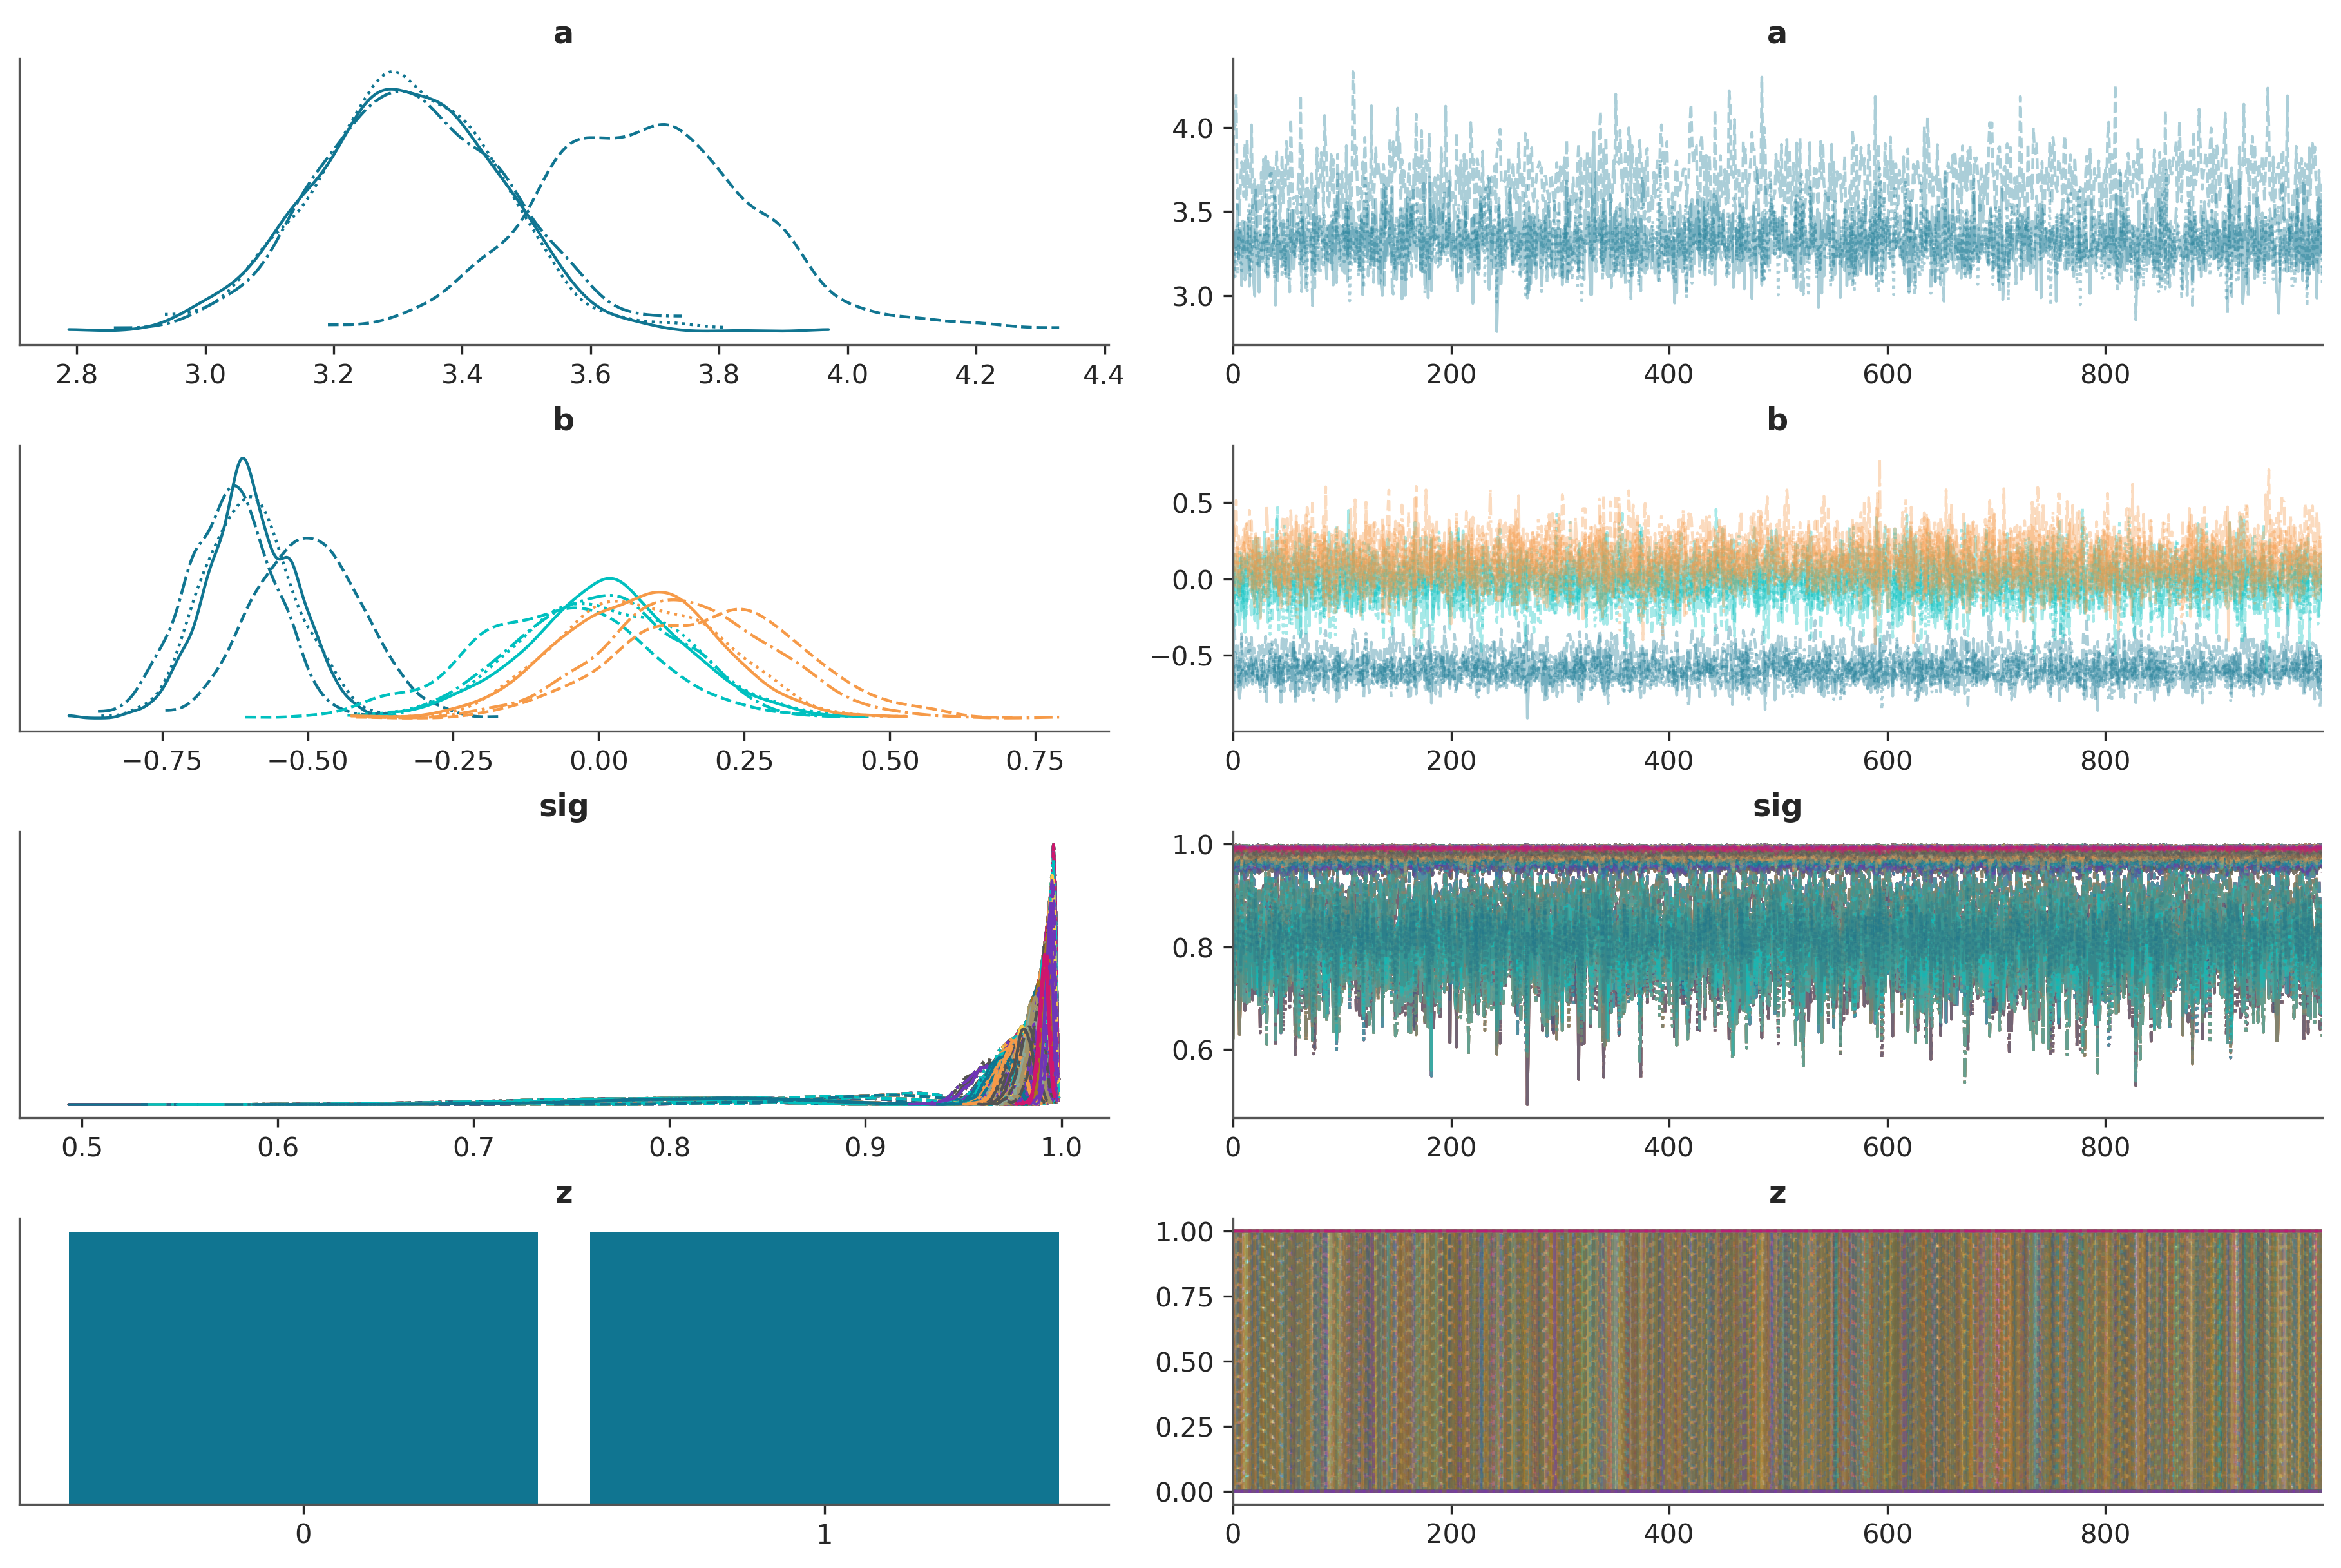

In [28]:
az.plot_trace(trace)

In [34]:
az.summary(trace)

/home/nuttidalab/miniconda3/envs/ssm/lib/python3.10/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/nuttidalab/miniconda3/envs/ssm/lib/python3.10/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/nuttidalab/miniconda3/envs/ssm/lib/python3.10/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: divide by zero encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/nuttidalab/miniconda3/envs/ssm/lib/python3.10/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/nuttidalab/miniconda3/env

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
a        3.408  0.221   3.021    3.838      0.082    0.061       9.0   
b[0]    -0.582  0.094  -0.754   -0.397      0.026    0.019      14.0   
b[1]    -0.013  0.146  -0.286    0.262      0.015    0.011      99.0   
b[2]     0.123  0.155  -0.164    0.409      0.027    0.019      34.0   
sig[0]   0.972  0.007   0.959    0.985      0.002    0.001      18.0   
...        ...    ...     ...      ...        ...      ...       ...   
z[2995]  1.000  0.000   1.000    1.000      0.000    0.000    4000.0   
z[2996]  1.000  0.000   1.000    1.000      0.000    0.000    4000.0   
z[2997]  1.000  0.000   1.000    1.000      0.000    0.000    4000.0   
z[2998]  1.000  0.000   1.000    1.000      0.000    0.000    4000.0   
z[2999]  1.000  0.000   1.000    1.000      0.000    0.000    4000.0   

         ess_tail  r_hat  
a            30.0   1.39  
b[0]         41.0   1.19  
b[1]       2009.0   1.03  
b[2]        163.0   1.08  
sig[0]       57.0   1.15  
...           ...    ...  
z[2995]    4000.0    NaN  
z[2996]    4000.0    NaN  
z[2997]    4000.0    NaN  
z[2998]    4000.0    NaN  
z[2999]    4000.0    NaN  

[6004 rows x 9 columns]

In [31]:
trace.posterior["b"].shape

(4, 1000, 3)

In [32]:
trace.posterior["b"].values.mean(axis=(0,1))

array([-0.58243827, -0.01280622,  0.12295478])

In [33]:
trace.posterior["a"].values.mean(axis=(0,1))

3.408236266275209

In [35]:
(trace.posterior["z"].values == 0).mean(), (trace.posterior["z"].values == 1).mean()

(0.01698558333333333, 0.9830144166666667)

Text(0, 0.5, 'sigmoid(z)')

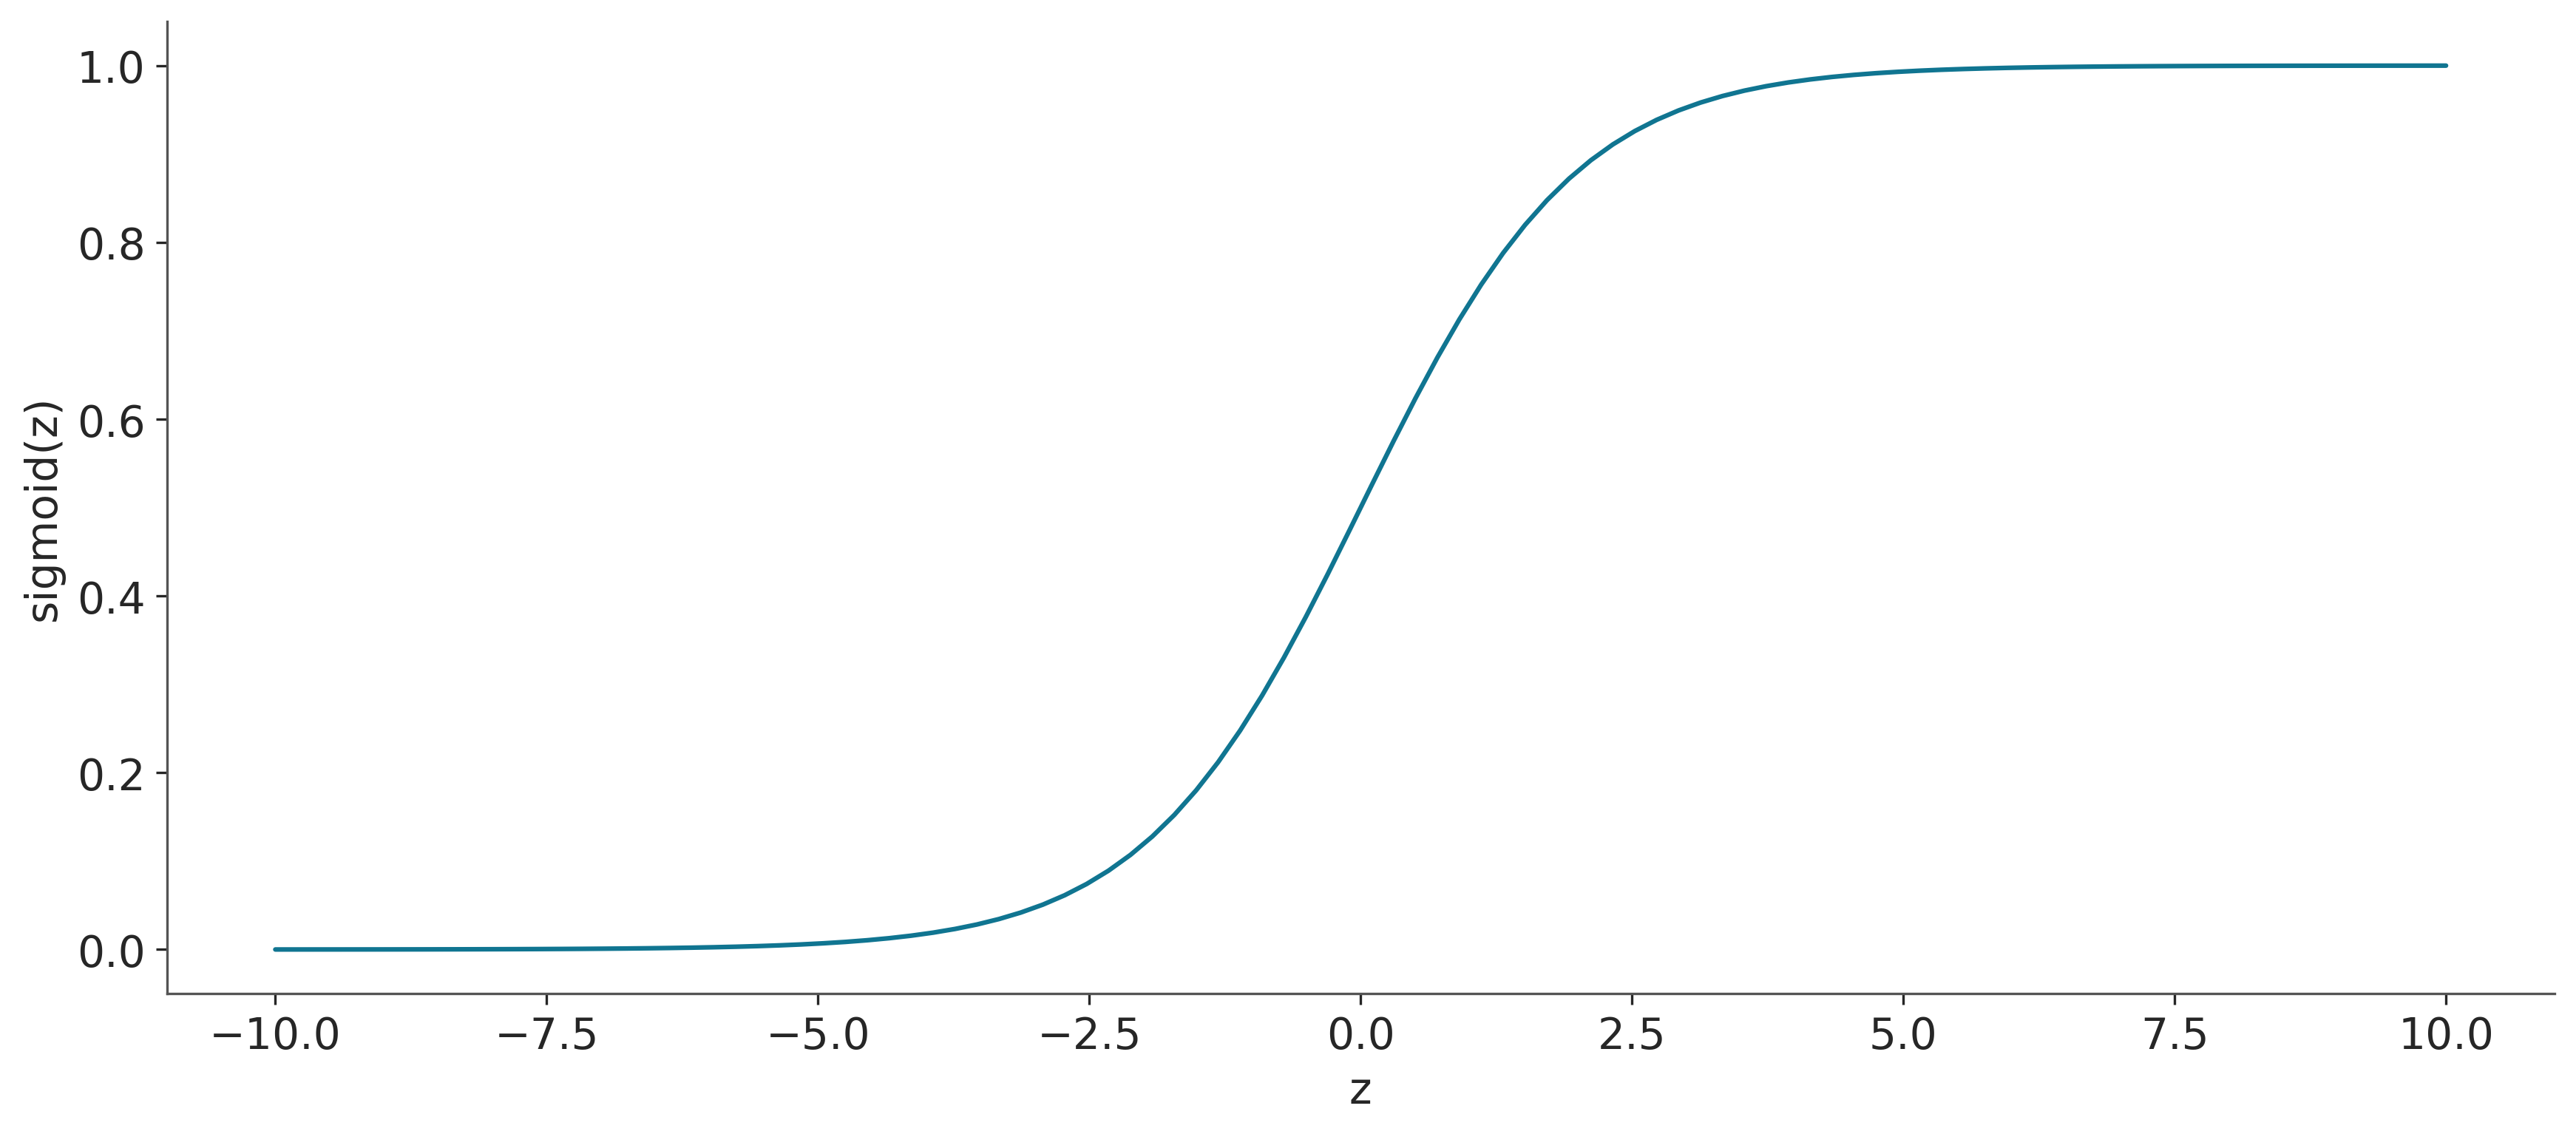

In [25]:
import matplotlib.pyplot as plt 
import numpy as np 

z = np.linspace(-10, 10, 100) 
def sigmoid(z):
    return 1/(1 + np.exp(-z))

a = sigmoid(z)
plt.plot(z, a) 
plt.xlabel("z") 
plt.ylabel("sigmoid(z)")

In [26]:
sigmoid(0)

0.5

## Mixture vec

\begin{align*}
p(z_t = 1 \mid x_t^{tr}) &= \sigma(a + b^\top x_t^{tr}) \\
z_t &\sim Bernoulli(p(z_t = 1 \mid x_t^{tr})) \\
p(y_t \mid x_t^{em}, z_t) &= 
\begin{cases} 
VonMises(\mu = w_0^\top x_t^{em} + c_0, \kappa = \kappa_0), & \text{if } z_t = 0 \\
VonMises(\mu = w_1^\top x_t^{em} + c_1, \kappa = \kappa_1), & \text{if } z_t = 1 \\
\end{cases}
\end{align*}

y_n | z_n = 0, x_{em} \sim \text{VonMises}(\mu = -0.21 \cdot x_t^{em} -2.05, \kappa = 2.27)

Your model can be defined mathematically as follows:

### Latent Variable (Expert Selection)
Let \( z_n \in \{0, 1\} \) be a binary variable indicating which expert is selected based on the input \( x_n \).

1. **Probability of Selecting Expert \( z_n = 1 \):**
   \[
   p(z_n = 1 | x_n) = \sigma(a + b^\top x_n)
   \]
   where \( \sigma(\cdot) \) is the sigmoid function, \( a \) is a scalar bias term, and \( b \) is a vector of weights.

2. **Distribution of \( z_n \):**
   \[
   z_n \sim \text{Bernoulli}(p(z_n = 1 | x_n))
   \]
   This means that \( z_n = 1 \) with probability \( p(z_n = 1 | x_n) \) and \( z_n = 0 \) otherwise.

### Output Variable (Observed Data)
Given \( z_n \), the output \( y_n \) is generated based on a von Mises distribution with parameters that depend on the value of \( z_n \).

1. **If \( z_n = 0 \):**
   \[
   y_n \sim \text{VonMises}(\mu = w_{mu, 0}^\top x_n + w_{it, 0}, \kappa = \kappa_0)
   \]
   
2. **If \( z_n = 1 \):**
   \[
   y_n \sim \text{VonMises}(\mu = w_{mu, 1}^\top x_n + w_{it, 1}, \kappa = \kappa_1)
   \]

Here:
- \( w_{mu, 0} \) and \( w_{mu, 1} \) are parameter vectors for the two experts, specifying the directional mean based on \( x_n \).
- \( w_{it, 0} \) and \( w_{it, 1} \) are scalar intercept terms specific to each expert.
- \( \kappa_0 \) and \( \kappa_1 \) are concentration parameters (precision) of the von Mises distribution, specific to each expert.

### Model Summary
The full model can be summarized as:
1. **Expert Selection (Latent Variable):**
   \[
   p(z_n = 1 | x_n) = \sigma(a + b^\top x_n)
   \]
   \[
   z_n \sim \text{Bernoulli}(p(z_n = 1 | x_n))
   \]

2. **Output Distribution (Conditional on \( z_n \)):**
   \[
   y_n | z_n = 0 \sim \text{VonMises}(\mu = w_{mu, 0}^\top x_n + w_{it, 0}, \kappa = \kappa_0)
   \]
   \[
   y_n | z_n = 1 \sim \text{VonMises}(\mu = w_{mu, 1}^\top x_n + w_{it, 1}, \kappa = \kappa_1)
   \]

This model captures a mixture of von Mises experts, where the probability of selecting each expert depends on the input \( x_n \) through a Bernoulli distribution. Each expert has its own mean and concentration parameters, allowing it to model circular data based on \( z_n \).